In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

import peakutils
from peakutils.plot import plot as pplot
%matplotlib inline


SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
mut_og = pd.read_csv('./TDR_data/TDR_updated_20200204/TDR_recal_MUT.csv',
                     index_col='date', parse_dates=True, header=0,dtype=np.float64,na_values='  NaN',
                     names=['date',0.0,0.3,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0])

k04_og = pd.read_csv('./TDR_data/TDR_updated_20200204/TDR_recal_K04.csv',
                     index_col='date', parse_dates=True, header=0,dtype=np.float64,na_values='  NaN',
                     names=['date',0.0,0.3,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0])

In [4]:
kj_kcl = pd.read_excel('./lysimeter_water/ForestSoyMaize_DeepSoilN_v2.xlsx',
                      sheet_name='Forest_Soy_Maize Profiles',na_values='')

kj_kcl_stats = kj_kcl.groupby(['Landuse','depth_m']).describe()


soil = pd.read_excel('./Soil_data/lysimeter_pits_2018/lysimeter_soil_data.xlsx',sheet_name='physical_props')
soil_dry = pd.concat([soil['sample'],soil['dry_mass_kg'],soil['GWC']],axis=1)
dil_factor = pd.read_excel('./Soil_data/lysimeter_pits_2018/lysimeter_soil_data.xlsx',sheet_name='DI_extract_calcs')
ion_kcl = pd.read_excel('./lysimeter_water/ions/results_summary.xlsx',sheet_name='KCl_extract_data',na_values='#NA')
ion_kcl = ion_kcl.merge(soil_dry, on='sample')
ion_kcl = ion_kcl.merge(dil_factor[['sample','ext_dil_factor']],on='sample')

# 0.05 L is the volume of extractant we used
ion_kcl['nitrate_mmolkg'] = (ion_kcl['nitrate_mM'] * 0.05) / ion_kcl['dry_mass_kg']
ion_kcl['sample'] = ion_kcl['sample'].str.split('-')   
for i in ion_kcl.index:
    ion_kcl.loc[i,'location'] = ion_kcl.loc[i,'sample'][0]
    ion_kcl.loc[i,'hole'] = ion_kcl.loc[i,'sample'][1]
    ion_kcl.loc[i,'depth'] = float(ion_kcl.loc[i,'sample'][2])
    
kcl_group = ion_kcl.groupby(['landuse','depth'])
kcl_stats = kcl_group.describe()

## Figures

In [5]:
def storage(df):
    storage = df.copy()
    layers = [10.] * 12 # 10 cm thickness around each TDR probe
    for l,c in zip(layers,df.columns):
        storage[c] = df[c] * l
    return storage

In [7]:
mut_stor = storage(mut_og)
k04_stor = storage(k04_og)

bottoms = np.array([15, 25, 35, 75, 100, 100, 100, 100, 100, 100, 100, 100], dtype='float64').cumsum()

In [8]:
mut_diff = (mut_stor.diff() / 6) * 10 # divide by six for the 6 hr interval, times 10 for cm-->mm
mut_diff.mask(mut_diff >= 0.000, np.nan, inplace=True)
mut_n = mut_diff.describe().loc['count',:]

k04_diff = (k04_stor.diff() / 6) * 10 # divide by six for the 6 hr interval
k04_diff.mask(k04_diff >= 0.000, np.nan, inplace=True)
k04_n = k04_diff.describe().loc['count',:]


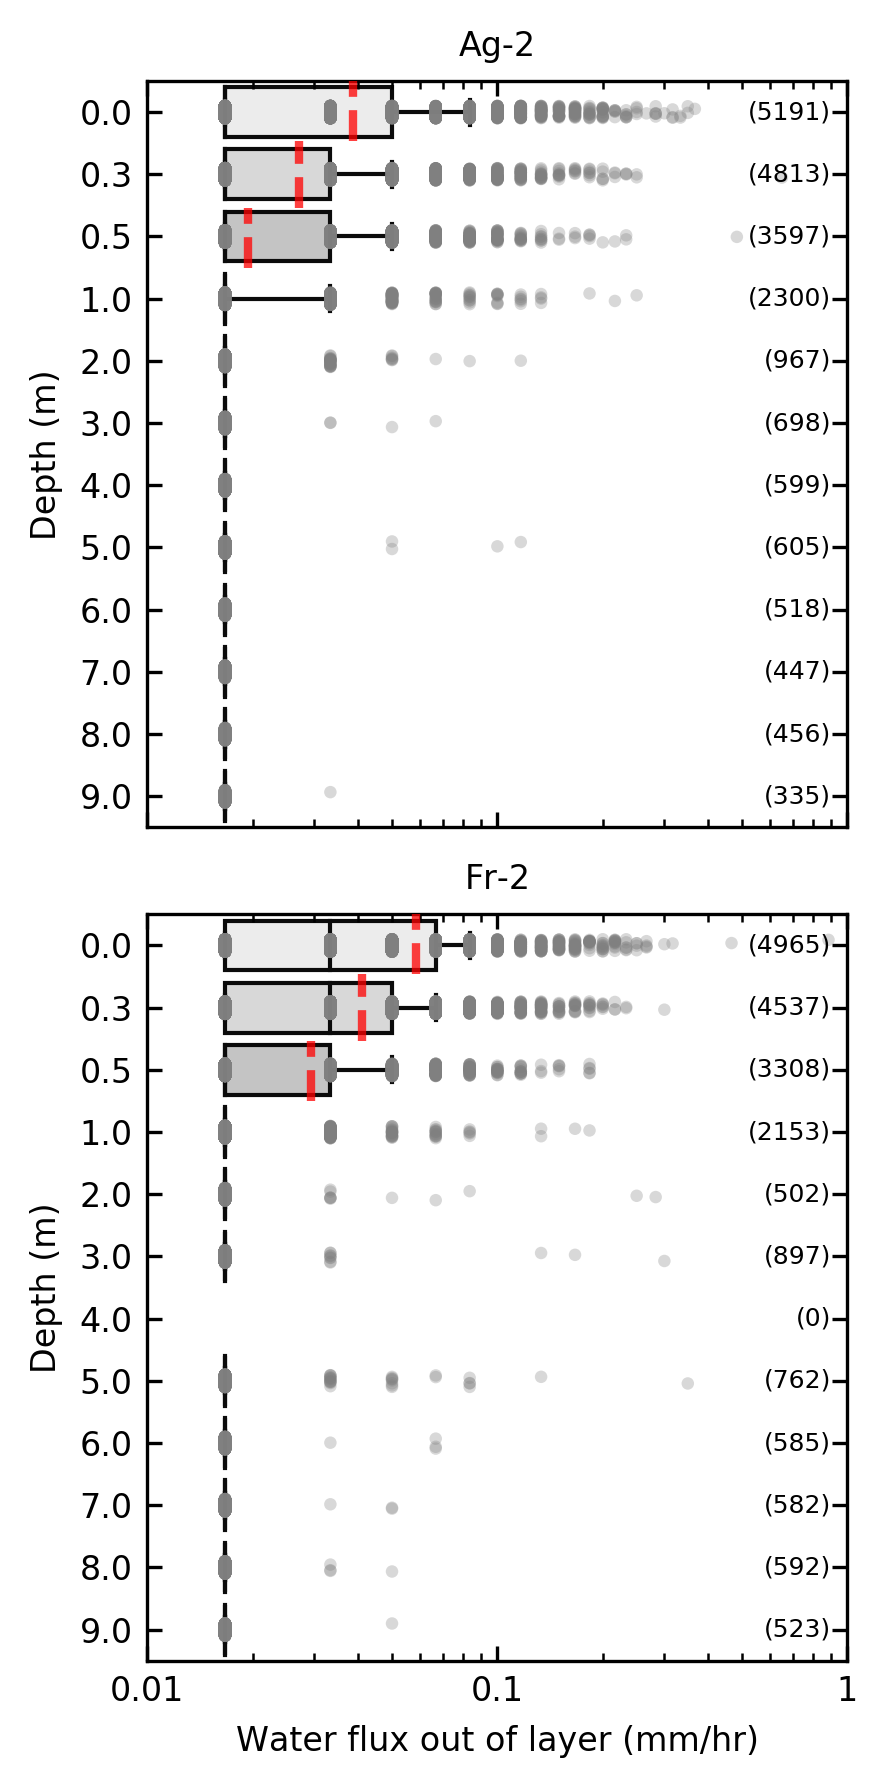

In [9]:
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(3,6),dpi=300,sharey=True,sharex=True)
data = mut_diff
sns.boxplot(data=-data,
            palette='gray_r',
            orient='h',
            whis=(10,90),
            showfliers=False,
            linewidth=1,
            ax=ax1)

sns.stripplot(
    data=-data,
    jitter=True,
    dodge=True, 
    marker='o',
    size=3,
    alpha=0.3,
    color='gray',
    orient='h',
    ax=ax1
)

data = k04_diff
sns.boxplot(data=-data,
            palette='gray_r', 
            orient='h',
            whis=(10,90),
            showfliers=False,
            linewidth=1,
            ax=ax2)

sns.stripplot(
    data=-data,
    jitter=True,
    dodge=True, 
    marker='o',
    size=3,
    alpha=0.3,
    color='gray',
    orient='h',
    ax=ax2
)

# assume that ET varies linearly over first 1 meter, see Notability for using trig to calculate
for_evap_yr = [512.5,
                358.75,
                256.25]
soy_evap_yr = [339.5,
                237.65,
                169.75]

for_evap_hr_halfYr = [x/182.5/24 for x in for_evap_yr] # assume most ET occurs during half of year...
soy_evap_hr_halfYr = [x/182.5/24 for x in soy_evap_yr] # assume most ET occurs during half of year...

for_evap_hr_fullYr = [x/365/24 for x in for_evap_yr] # even ET all year
soy_evap_hr_fullYr = [x/365/24 for x in soy_evap_yr] # even ET all year

width=2

ax1.axvline(soy_evap_hr_fullYr[0],lw=width,ls='--',color='r',alpha=.75,ymin=.92,zorder=3)
ax1.axvline(soy_evap_hr_fullYr[1],lw=width,ls='--',color='r',alpha=.75,ymax=.92,ymin=.83,zorder=3)
ax1.axvline(soy_evap_hr_fullYr[2],lw=width,ls='--',color='r',alpha=.75,ymax=.83,ymin=.75,zorder=3)

ax2.axvline(for_evap_hr_fullYr[0],lw=width,ls='--',color='r',alpha=.75,ymin=.92,zorder=3)
ax2.axvline(for_evap_hr_fullYr[1],lw=width,ls='--',color='r',alpha=.75,ymax=.92,ymin=.83,zorder=3)
ax2.axvline(for_evap_hr_fullYr[2],lw=width,ls='--',color='r',alpha=.75,ymax=.83,ymin=.75,zorder=3)

ax1.set_xscale('log')
ax1.set_xlim(10**-2,10**0)
ax1.set_title('Ag-2')
ax2.set_title('Fr-2')

ax2.set_xlabel('Water flux out of layer (mm/hr)')

for ax in (ax1,ax2):
    
    ax.set_ylabel('Depth (m)')
    if ax1.get_xscale() == 'log':
        ax.xaxis.set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda y,
                                            pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
    
for i,n in enumerate(mut_n):
    ax1.annotate('({})'.format(round(n)),xy=(.9,i),fontsize=6,va='center',ha='right')
    
for i,n in enumerate(k04_n):
    ax2.annotate('({})'.format(round(n)),xy=(.9,i),fontsize=6,va='center',ha='right')
    
    
ax1.tick_params(axis='both',which='both',direction='in',top=True,right=True)
ax2.tick_params(axis='both',which='both',direction='in',top=True,right=True)
fig.tight_layout()
fig.patch.set_facecolor('w')

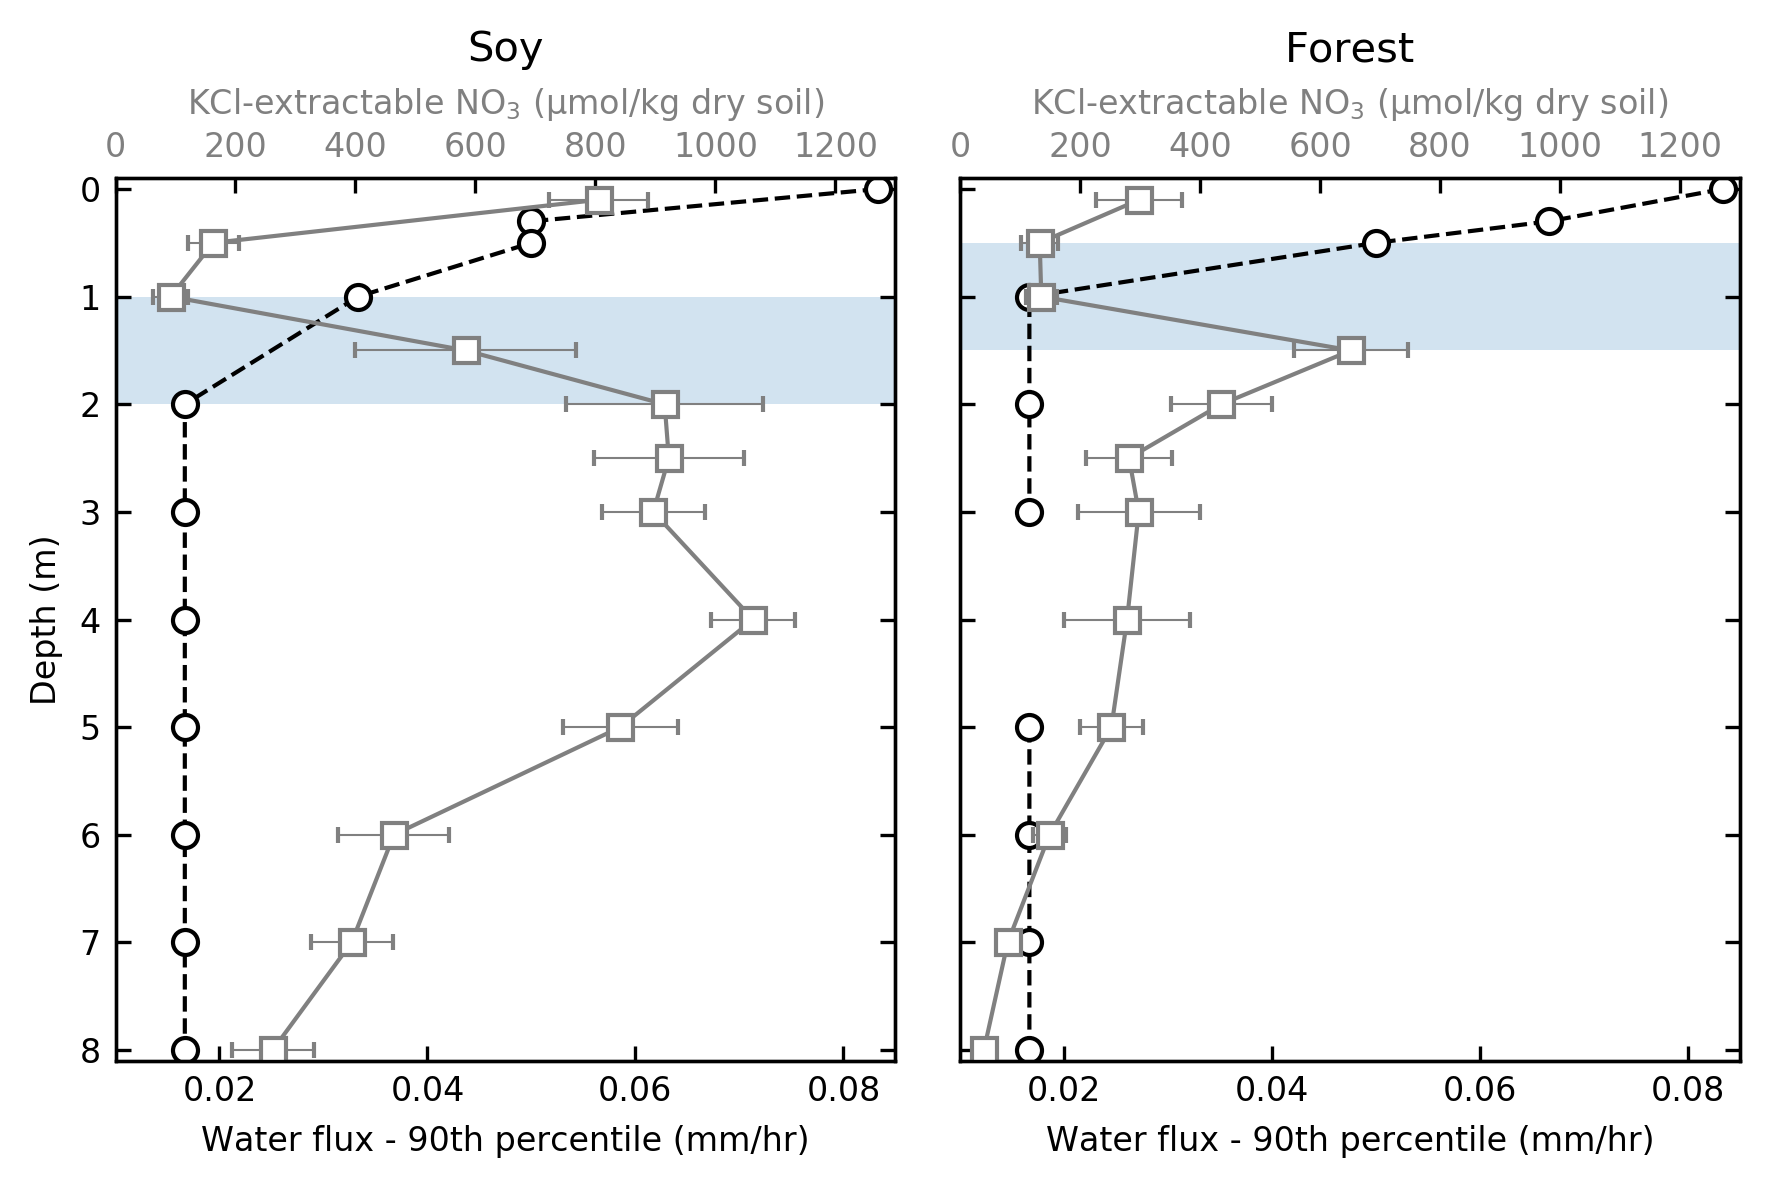

In [10]:
q = 0.1
lw = 1
fig,ax = plt.subplots(1,2,figsize=(6,4),dpi=300,sharex=True,sharey=True)
df=mut_diff
n = len(df)
ax[0].plot(-df.quantile(q).values,df.columns.values,'--o',color='k',
           linewidth=lw, markerfacecolor='w', label='{} percentile'.format(1-q))
# ax[0].plot(-df.quantile(q).values,df.columns.values,alpha=0.7,facecolor='k',edgecolor='k',
#               label='{} percentile'.format(1-q))
# ax[0].scatter(x=df.min().values,y=df.columns.values,marker='+',color='k',label='Max')


df=k04_diff
n = len(df)
ax[1].plot(-df.quantile(q).values,df.columns.values,'--o',color='k',
           linewidth=lw, markerfacecolor='w', label='{} percentile'.format(1-q))
# ax[1].scatter(-df.quantile(q).values,df.columns.values,alpha=0.7,facecolor='k',edgecolor='k',
#               label='{} percentile'.format(1-q))
# ax[1].scatter(x=df.min().values,y=df.columns.values,marker='+',color='k',label='Max')

ax[0].set_yticks(np.arange(0,10,1))
ax[0].set_ylim(8.1,-0.1)
ax[0].set_xlim(.01,0.085)


ax[0].set_xlabel('Water flux - 90th percentile (mm/hr)',color='k')
ax[1].set_xlabel('Water flux - 90th percentile (mm/hr)',color='k')

ax[0].tick_params(axis='x',labelcolor='k')
ax[1].tick_params(axis='x',labelcolor='k')

ax[0].set_ylabel('Depth (m)')
# ax[1].set_ylabel('Depth (m)')

# ax[0].legend(loc='lower right')
# ax[1].legend(loc='lower right')

ax[0].tick_params('both',direction='in',right=True)
ax[1].tick_params('both',direction='in',right=True)
ax[0].set_title('Soy',size=10)
ax[1].set_title('Forest',size=10)

# plot nitrate data
df = kj_kcl_stats.loc['soybean']
x = df['nitrate_mmolkg']['mean']*1000
xerr = df['nitrate_mmolkg']['std']*1000 / np.sqrt(df['nitrate_mmolkg']['count'])
ax2 = ax[0].twiny()
ax2.errorbar(x=x,y=df.index,xerr=xerr,label='2015',
            fmt='s-',linewidth=lw,elinewidth=0.5,capsize=2,color='gray',markerfacecolor='w')
df = kj_kcl_stats.loc['forest']
x = df['nitrate_mmolkg']['mean']*1000
xerr = df['nitrate_mmolkg']['std']*1000 / np.sqrt(df['nitrate_mmolkg']['count'])
ax3 = ax[1].twiny()
ax3.errorbar(x=x,y=df.index,xerr=xerr,label='2015',
            fmt='s-',linewidth=lw,elinewidth=.5,capsize=2,color='gray',markerfacecolor='w')

# df = kcl_stats.loc['soybean']
# ax2.errorbar(x=df['nitrate_mmolkg']['mean'],y=df.index,xerr=df['nitrate_mmolkg']['std'],label='2019',
#             fmt='^-',linewidth=lw,elinewidth=0.5,capsize=2,color='k',markerfacecolor='None')
# df = kcl_stats.loc['forest']
# ax3.errorbar(x=df['nitrate_mmolkg']['mean'],y=df.index,xerr=df['nitrate_mmolkg']['std'],label='2019',
#             fmt='^-',linewidth=lw,elinewidth=.5,capsize=2,color='k',markerfacecolor='None')
ax2.set_xlim(0,1300)
ax3.set_xlim(0,1300)
# ax[0].fill_between((0,1),1,2,alpha=.2,zorder=-1,facecolor='k',edgecolor='None')
# ax[1].fill_between((0,1),1,1.5,alpha=.2,zorder=-1,facecolor='k',edgecolor='None')

ax2.set_xlabel('KCl-extractable NO$_3$ (μmol/kg dry soil)',color='gray')
ax3.set_xlabel('KCl-extractable NO$_3$ (μmol/kg dry soil)',color='gray')

ax2.tick_params(axis='x',labelcolor='gray')
ax2.tick_params(direction='in',top=True)
ax3.tick_params(axis='x',labelcolor='gray')
ax3.tick_params(direction='in',top=True)

# ax[0].annotate(xy=(),)
ax[0].fill_between((0,1),1.,2,alpha=.2,zorder=-1,facecolor='tab:blue',edgecolor=None)
ax[1].fill_between((0,1),.5,1.5,alpha=.2,zorder=-1,facecolor='tab:blue',edgecolor=None)

fig.tight_layout()
fig.patch.set_facecolor('w')